In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import time
import copy
import gc
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
writer = SummaryWriter(log_dir="runs")

In [15]:
BATCH_SIZE = 64
NUM_WORKERS = 2

In [16]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

In [17]:
# transforms labels to one-hot vectors
def label_transform(image):
    ls = []
    for d in image['annotation']['object']:
        ls.append(class_names.index(d['name']))

    indices = np.zeros(shape=(len(class_names)))
    for d in image['annotation']['object']:
        indices[class_names.index(d['name'])] = 1

    return torch.from_numpy(indices)

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'trainval': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
image_datasets = {x: torchvision.datasets.voc.VOCDetection(root=f"data/{x}", year="2007", image_set=x, download=True, transform=data_transforms[x], target_transform=label_transform)
                  for x in ['train', 'trainval', 'test']}

Using downloaded and verified file: data/train/VOCtrainval_06-Nov-2007.tar
Extracting data/train/VOCtrainval_06-Nov-2007.tar to data/train
Using downloaded and verified file: data/trainval/VOCtrainval_06-Nov-2007.tar
Extracting data/trainval/VOCtrainval_06-Nov-2007.tar to data/trainval
Using downloaded and verified file: data/test/VOCtest_06-Nov-2007.tar
Extracting data/test/VOCtest_06-Nov-2007.tar to data/test


In [20]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
               for x in ['train', 'trainval', 'test']}

In [21]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'trainval', 'test']}

In [25]:
dataset_sizes

{'train': 2501, 'trainval': 5011, 'test': 4952}

In [26]:
count_dict = {class_name: 0 for class_name in class_names}
for i in range(len(image_datasets['train'])):
    for target in np.array(class_names)[np.where(image_datasets['train'][i][1])]:
        count_dict[target] +=1

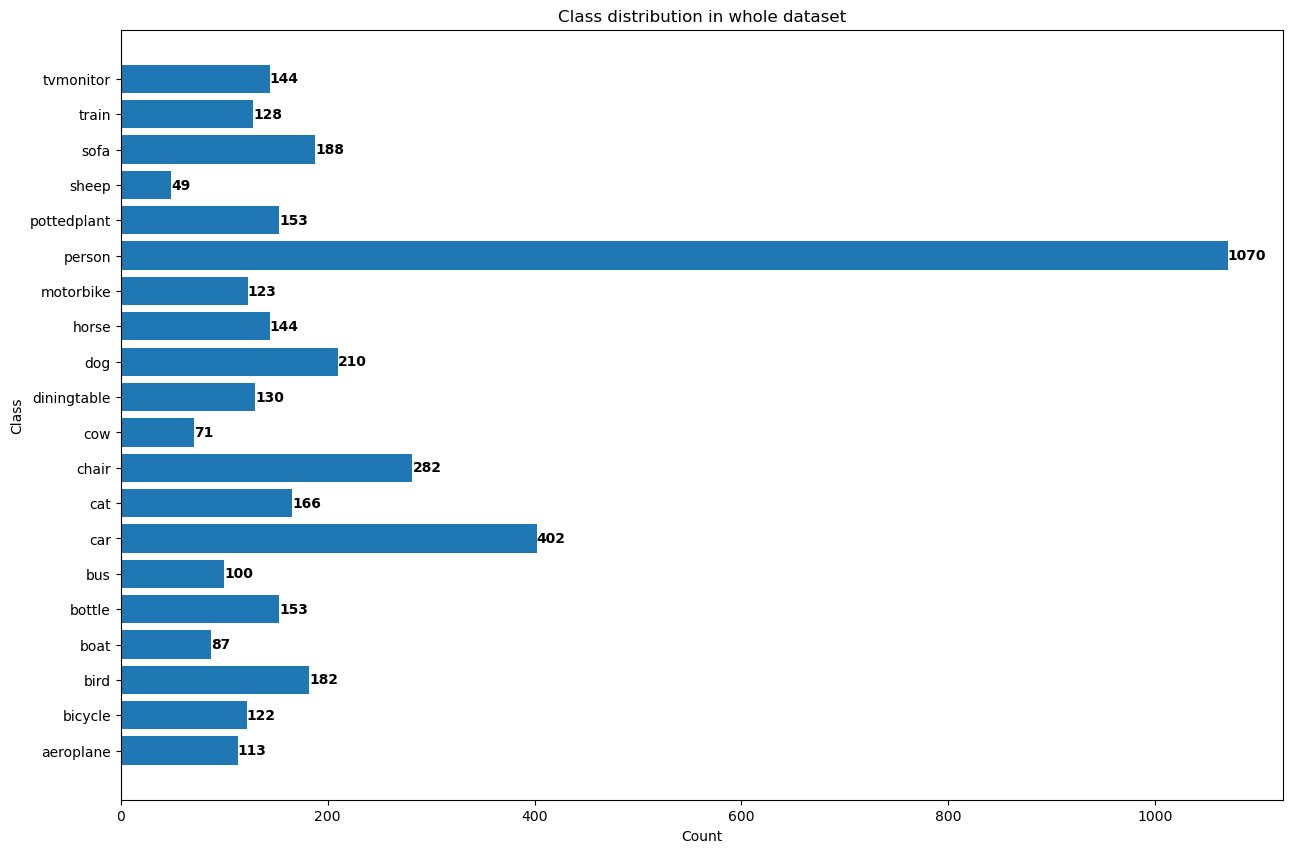

In [27]:
plt.figure(figsize=(15,10))
plt.barh(y=list(count_dict.keys()), width=list(count_dict.values()))
plt.title('Class distribution in whole dataset')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(list(count_dict.values())):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

In [28]:
def ap_score(y_true, y_scores):
    return np.sum([average_precision_score(y_true = y_true[i], y_score = y_scores[i]) for i in range(y_true.shape[0])])

In [29]:
def train_model(model, criterion, optimizer, scheduler, threshold=0.5, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_map = 0.0
    stats = {
        'train': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        },
        'trainval': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        }
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'trainval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_micro_f1 = 0.0
            running_samples_f1 = 0.0
            running_ap = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_micro_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="micro")
                running_samples_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="samples")
                running_ap += ap_score(y_true=labels.cpu().detach().numpy(), y_scores=torch.sigmoid(outputs).cpu().detach().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_micro_f1 = running_micro_f1 / dataset_sizes[phase]
            epoch_samples_f1 = running_samples_f1 / dataset_sizes[phase]
            epoch_map = running_ap / dataset_sizes[phase]

            stats[phase]['iterations'].append(epoch)
            stats[phase]['losses'].append(epoch_loss)
            stats[phase]['micro_f1'].append(epoch_micro_f1)
            stats[phase]['samples_f1'].append(epoch_samples_f1)
            stats[phase]['maps'].append(epoch_map)

            print('{} Loss: {:.4f} Mean Average Precision: {:.4f} Mean Micro F1: {:.4f} Mean Samples F1: {:.4f}'.format(
                phase, epoch_loss, epoch_map, epoch_micro_f1, epoch_samples_f1))
            writer.add_scalar(f"{phase} loss", epoch_loss, epoch)
            writer.add_scalar(f"{phase} mean average precision", epoch_map, epoch)
            writer.add_scalar(f"{phase} micro f1", epoch_micro_f1, epoch)
            writer.add_scalar(f"{phase} samples f1", epoch_samples_f1, epoch)

            # clear variables
            del inputs, labels, outputs
            gc.collect()
            torch.cuda.empty_cache()

            # deep copy the model
            if phase == 'trainval' and epoch_map > best_map:
                best_map = epoch_map
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Mean Average Precision: {:4f}'.format(best_map))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stats

In [30]:
def test_model(model, criterion, threshold=0.5):

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_micro_f1 = 0.0
    running_samples_f1 = 0.0
    running_ap = 0.0
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.sigmoid(outputs) > threshold

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_micro_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="micro")
            running_samples_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="samples")
            running_ap += ap_score(y_true=labels.cpu().detach().numpy(), y_scores=torch.sigmoid(outputs).cpu().detach().numpy())
            y_pred_all.extend(preds.cpu().detach().numpy())
            y_true_all.extend(labels.cpu().detach().numpy())

    mean_loss = running_loss / dataset_sizes['test']
    mean_micro_f1 = running_micro_f1 / dataset_sizes['test']
    mean_samples_f1 = running_samples_f1 / dataset_sizes['test']
    mean_ap = running_ap / dataset_sizes['test']

    print('Mean Loss: {:.4f} Mean Average Precision: {:.4f} Mean Micro F1: {:.4f} Mean Samples F1: {:.4f}'.format(mean_loss, mean_ap, mean_micro_f1, mean_samples_f1))
    return y_true_all,y_pred_all

In [31]:
def visualize_model(model, threshold=0.5, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > threshold

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print('predicted: {}, ground truth: {}'.format(" ".join([class_names[i] for i in range(len(preds[j])) if preds[j][i]]),  " ".join([class_names[i] for i in range(len(labels[j])) if labels[j][i]])))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
def plot_training(stats):
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['losses'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['losses'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.subplot(1,4,2)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['micro_f1'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['micro_f1'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Micro F1")
    plt.legend(loc='best')

    plt.subplot(1,4,3)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['samples_f1'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['samples_f1'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Samples F1")
    plt.legend(loc='best')

    plt.subplot(1,4,4)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['maps'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['maps'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Average Precision")
    plt.legend(loc='best')

    plt.show()

In [33]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.Linear(256, len(class_names))
)

model_conv = model_conv.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
model_conv, stats = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=20)

Epoch 0/19
----------
train Loss: 297.8805 Mean Average Precision: 0.5860 Mean Micro F1: 0.0055 Mean Samples F1: 0.0044
trainval Loss: 183.1991 Mean Average Precision: 0.8385 Mean Micro F1: 0.0099 Mean Samples F1: 0.0088

Epoch 1/19
----------
train Loss: 180.5728 Mean Average Precision: 0.8101 Mean Micro F1: 0.0096 Mean Samples F1: 0.0085
trainval Loss: 156.8210 Mean Average Precision: 0.8419 Mean Micro F1: 0.0110 Mean Samples F1: 0.0107

Epoch 2/19
----------
train Loss: 155.6083 Mean Average Precision: 0.8523 Mean Micro F1: 0.0107 Mean Samples F1: 0.0100
trainval Loss: 131.2994 Mean Average Precision: 0.8961 Mean Micro F1: 0.0119 Mean Samples F1: 0.0117

Epoch 3/19
----------
train Loss: 145.1738 Mean Average Precision: 0.8716 Mean Micro F1: 0.0112 Mean Samples F1: 0.0107
trainval Loss: 124.0464 Mean Average Precision: 0.9087 Mean Micro F1: 0.0119 Mean Samples F1: 0.0116

Epoch 4/19
----------
train Loss: 139.4041 Mean Average Precision: 0.8812 Mean Micro F1: 0.0116 Mean Samples F1:

In [36]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

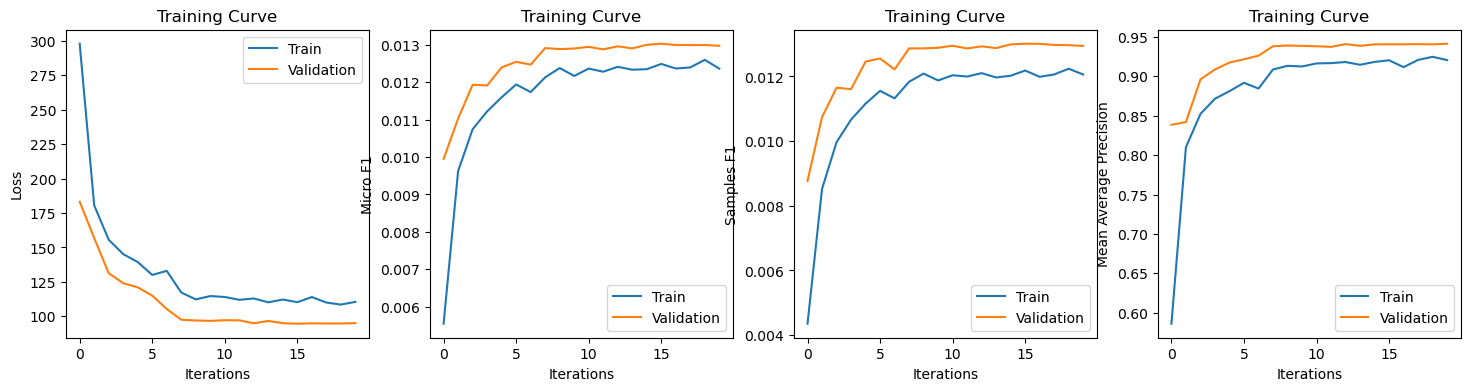

In [37]:
plot_training(stats)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


predicted: car, ground truth: car


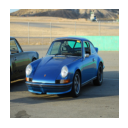

predicted: bird, ground truth: bird


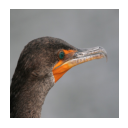

predicted: tvmonitor, ground truth: tvmonitor


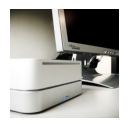

predicted: sofa, ground truth: sofa


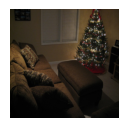

predicted: bicycle motorbike person, ground truth: bicycle person


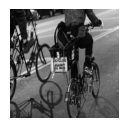

predicted: bus train, ground truth: train


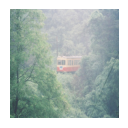

In [29]:
visualize_model(model_conv)

In [30]:
y_true, y_pred = test_model(model_conv, criterion)

Mean Loss: 102.5237 Mean Average Precision: 0.9262 Mean Micro F1: 0.0125 Mean Samples F1: 0.0125


In [29]:
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support



   aeroplane       0.96      0.89      0.92       205

     bicycle       0.91      0.81      0.86       250

        bird       0.94      0.82      0.88       289

        boat       0.89      0.87      0.88       176

      bottle       0.61      0.48      0.53       240

         bus       0.82      0.72      0.77       183

         car       0.87      0.80      0.83       775

         cat       0.93      0.79      0.86       332

       chair       0.67      0.62      0.64       545

         cow       0.69      0.64      0.66       127

 diningtable       0.74      0.66      0.69       247

         dog       0.94      0.76      0.84       433

       horse       0.88      0.88      0.88       279

   motorbike       0.88      0.79      0.83       233

      person       0.91      0.83      0.87      2097

 pottedplant       0.61      0.50      0.55       254

       sheep       0.83      0.72      0.77        98

        

In [38]:
model_conv = models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [39]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [40]:
model_conv, stats = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=2)

Epoch 0/1
----------
train Loss: 281.7491 Mean Average Precision: 0.6258 Mean Micro F1: 0.0066 Mean Samples F1: 0.0054
trainval Loss: 165.4680 Mean Average Precision: 0.8881 Mean Micro F1: 0.0116 Mean Samples F1: 0.0112

Epoch 1/1
----------
train Loss: 163.9208 Mean Average Precision: 0.8404 Mean Micro F1: 0.0104 Mean Samples F1: 0.0094
trainval Loss: 127.3766 Mean Average Precision: 0.9198 Mean Micro F1: 0.0124 Mean Samples F1: 0.0124

Training complete in 2m 24s
Best val Mean Average Precision: 0.919850


In [ ]:
model_conv

In [ ]:
plot_training(stats)

In [ ]:
visualize_model(model_conv)

In [ ]:
y_true, y_pred = test_model(model_conv, criterion)

In [41]:
model_conv = models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [42]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [44]:
def train_inception(model, criterion, optimizer, scheduler, threshold=0.5, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_map = 0.0
    stats = {
        'train': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        },
        'trainval': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        }
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'trainval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_micro_f1 = 0.0
            running_samples_f1 = 0.0
            running_ap = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                            outputs = outputs[0]
                    
                    output_tensor = outputs[0]
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_micro_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="micro")
                running_samples_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="samples")
                running_ap += ap_score(y_true=labels.cpu().detach().numpy(), y_scores=torch.sigmoid(outputs).cpu().detach().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_micro_f1 = running_micro_f1 / dataset_sizes[phase]
            epoch_samples_f1 = running_samples_f1 / dataset_sizes[phase]
            epoch_map = running_ap / dataset_sizes[phase]

            stats[phase]['iterations'].append(epoch)
            stats[phase]['losses'].append(epoch_loss)
            stats[phase]['micro_f1'].append(epoch_micro_f1)
            stats[phase]['samples_f1'].append(epoch_samples_f1)
            stats[phase]['maps'].append(epoch_map)

            print('{} Loss: {:.4f} Mean Average Precision: {:.4f} Mean Micro F1: {:.4f} Mean Samples F1: {:.4f}'.format(
                phase, epoch_loss, epoch_map, epoch_micro_f1, epoch_samples_f1))
            writer.add_scalar(f"{phase} loss", epoch_loss, epoch)
            writer.add_scalar(f"{phase} mean average precision", epoch_map, epoch)
            writer.add_scalar(f"{phase} micro f1", epoch_micro_f1, epoch)
            writer.add_scalar(f"{phase} samples f1", epoch_samples_f1, epoch)

            # clear variables
            del inputs, labels, outputs
            gc.collect()
            torch.cuda.empty_cache()

            # deep copy the model
            if phase == 'trainval' and epoch_map > best_map:
                best_map = epoch_map
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Mean Average Precision: {:4f}'.format(best_map))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stats

In [45]:
model_conv, stats = train_inception(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=2)

Epoch 0/1
----------
train Loss: 355.3384 Mean Average Precision: 0.4468 Mean Micro F1: 0.0032 Mean Samples F1: 0.0022
trainval Loss: 273.0466 Mean Average Precision: 0.6239 Mean Micro F1: 0.0050 Mean Samples F1: 0.0034

Epoch 1/1
----------
train Loss: 254.9242 Mean Average Precision: 0.6517 Mean Micro F1: 0.0055 Mean Samples F1: 0.0041
trainval Loss: 218.5443 Mean Average Precision: 0.7615 Mean Micro F1: 0.0074 Mean Samples F1: 0.0058

Training complete in 2m 4s
Best val Mean Average Precision: 0.761507


In [46]:
model_conv

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
plot_training(stats)

In [ ]:
visualize_model(model_conv)

In [ ]:
y_true, y_pred = test_model(model_conv, criterion)

In [47]:
model_conv = models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [48]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
model_conv, stats = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=2)

Epoch 0/1
----------
train Loss: 312.7978 Mean Average Precision: 0.5023 Mean Micro F1: 0.0043 Mean Samples F1: 0.0029
trainval Loss: 246.5179 Mean Average Precision: 0.6491 Mean Micro F1: 0.0055 Mean Samples F1: 0.0041

Epoch 1/1
----------
train Loss: 236.4712 Mean Average Precision: 0.6820 Mean Micro F1: 0.0061 Mean Samples F1: 0.0046
trainval Loss: 197.4091 Mean Average Precision: 0.7968 Mean Micro F1: 0.0081 Mean Samples F1: 0.0067

Training complete in 1m 58s
Best val Mean Average Precision: 0.796801


In [51]:
model_conv

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
plot_training(stats)

In [ ]:
visualize_model(model_conv)

In [ ]:
y_true, y_pred = test_model(model_conv, criterion)

In [52]:
model_conv = models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [53]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [55]:
model_conv, stats = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=2)

Epoch 0/1
----------
train Loss: 309.9699 Mean Average Precision: 0.4834 Mean Micro F1: 0.0043 Mean Samples F1: 0.0030
trainval Loss: 261.2431 Mean Average Precision: 0.6109 Mean Micro F1: 0.0061 Mean Samples F1: 0.0045

Epoch 1/1
----------
train Loss: 243.0183 Mean Average Precision: 0.6703 Mean Micro F1: 0.0061 Mean Samples F1: 0.0046
trainval Loss: 210.8427 Mean Average Precision: 0.7793 Mean Micro F1: 0.0070 Mean Samples F1: 0.0055

Training complete in 2m 10s
Best val Mean Average Precision: 0.779349


In [ ]:
model_conv

In [ ]:
plot_training(stats)

In [ ]:
visualize_model(model_conv)

In [ ]:
y_true, y_pred = test_model(model_conv, criterion)